In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score

## Load data

In [2]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
# y_test = np.load("y_test.npy")

In [3]:
# 7000 data with 300 features
print(x_train.shape)

(7000, 300)


In [4]:
# It's a binary classification problem 
print(np.unique(y_train))

[0 1]


## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [5]:
def cross_validation(x_train, y_train, k=5):
    
    # first, we initialize our index
    idx = np.arange(0, x_train.shape[0], 1, int)
    # and shuffle it
    np.random.shuffle(idx)
    
    # making folds: k folds
    folds = np.array_split(idx, k, axis=0)
    folds = np.array(folds)
    
    cv_list = []
    for i in range(k):
        # delete the selected fold from train fold
        train_fold = np.delete(np.arange(k), i)
        
        # Each element is a list contains two parts, 
        # the first part contains the index of all training folds,
        # the second part contains the index of validation fold
        cv_list.append([np.concatenate(folds[train_fold]), folds[i]])
    
    return cv_list

In [6]:
kfold_data = cross_validation(x_train, y_train, k=10)
assert len(kfold_data) == 10 # should contain 10 fold of data
assert len(kfold_data[0]) == 2 # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 700 # The number of data in each validation fold should equal to training data divieded by K

In [7]:
# test the K-fold cross-validation function with example below
X = np.arange(20)
kf = cross_validation(X, X, k=5)
for i, (train_index, val_index) in enumerate(kf):
    print("Split: %s, Training index: %s, Validation index: %s" % (i+1, train_index, val_index))

Split: 1, Training index: [ 0 19 14 12  3  6 16  7  8  1 10 18  2  5 13  9], Validation index: [17 11 15  4]
Split: 2, Training index: [17 11 15  4  3  6 16  7  8  1 10 18  2  5 13  9], Validation index: [ 0 19 14 12]
Split: 3, Training index: [17 11 15  4  0 19 14 12  8  1 10 18  2  5 13  9], Validation index: [ 3  6 16  7]
Split: 4, Training index: [17 11 15  4  0 19 14 12  3  6 16  7  2  5 13  9], Validation index: [ 8  1 10 18]
Split: 5, Training index: [17 11 15  4  0 19 14 12  3  6 16  7  8  1 10 18], Validation index: [ 2  5 13  9]


## example

In [8]:
from sklearn.model_selection import KFold

X = np.arange(20)
kf = KFold(n_splits=5, shuffle=True)
kfold_data= []
for i, (train_index, val_index) in enumerate(kf.split(X)):
    print("Split: %s, Training index: %s, Validation index: %s" % (i+1, train_index, val_index))
    kfold_data.append([train_index, val_index])

Split: 1, Training index: [ 0  1  2  3  4  5  6  8 10 12 13 14 15 16 18 19], Validation index: [ 7  9 11 17]
Split: 2, Training index: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 16 17], Validation index: [ 2 15 18 19]
Split: 3, Training index: [ 0  1  2  3  5  7  9 10 11 12 13 15 16 17 18 19], Validation index: [ 4  6  8 14]
Split: 4, Training index: [ 1  2  3  4  6  7  8  9 10 11 14 15 16 17 18 19], Validation index: [ 0  5 12 13]
Split: 5, Training index: [ 0  2  4  5  6  7  8  9 11 12 13 14 15 17 18 19], Validation index: [ 1  3 10 16]


In [9]:
assert len(kfold_data) == 5 # should contain 5 fold of data
assert len(kfold_data[0]) == 2 # each element should contains index of training fold and validation fold
assert kfold_data[0][1].shape[0] == 4 # The number of data in each validation fold should equal to training data divieded by K

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C” and “gamma” to find the best parameters by cross-validation.

In [10]:
clf = SVC(C=1.0, kernel='rbf', gamma=0.01)

In [11]:
C = [0.0001, 0.01, 1, 100, 10000]
gamma = [5e-6, 1e-5, 5e-5, 1e-4, 5e-4]

# use cross-validation
cv_list = cross_validation(x_train, y_train, k=5)
# initialize grid
grid_result = np.zeros((len(C), len(gamma)))

# record best score and hyperparameter
best_score = -100
best_hyperparameter = [0, 0]

# train SVC by grid search of C and gamma
for i in range(len(C)):
    for j in range(len(gamma)):
        score = 0
        
        for traing_idxs, validation_idxs in cv_list:
            clf = SVC(C=C[i], kernel='rbf', gamma=gamma[j])
            clf.fit(x_train[traing_idxs], y_train[traing_idxs])
            score += clf.score(x_train[validation_idxs], y_train[validation_idxs])
        grid_result[i][j] = score / len(cv_list)
        
        if grid_result[i][j] > best_score:
            best_score = grid_result[i][j]
            best_hyperparameter = [C[i], gamma[j]]

In [12]:
print(f'Best C={best_hyperparameter[0]}, gamma={best_hyperparameter[1]}')

Best C=1, gamma=0.0001


## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like this reference image below ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

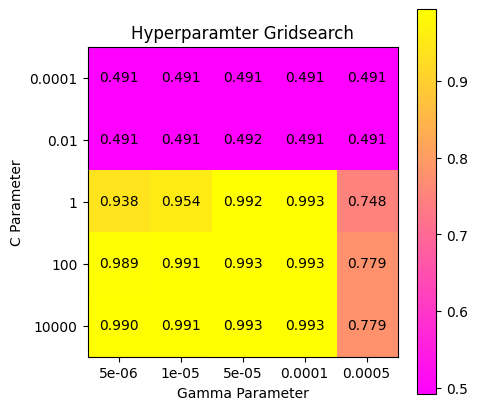

In [13]:
# Plot the grid search results of SVM
plt.figure(figsize=(5, 5))
plt.imshow(grid_result, cmap='spring', interpolation='nearest')
plt.title("Hyperparamter Gridsearch")
plt.xlabel("Gamma Parameter")
plt.xticks(np.arange(len(gamma)), gamma)
plt.ylabel("C Parameter")
plt.yticks(np.arange(len(C)), C)
plt.colorbar()

# add validation score to the heatmap
for i in range(len(C)):
    for j in range(len(gamma)):
        plt.text(j, i, f'{grid_result[i][j]:.3f}', ha='center', va='center', color='black')

plt.show()

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set.

In [16]:
import pickle

In [17]:
best_model = SVC(C=1, kernel='rbf', gamma=0.0001)
best_model.fit(x_train, y_train)

SVC(C=1, gamma=0.0001)

In [18]:
y_pred = best_model.predict(x_test)

In [20]:
with open('model.pickle', 'wb') as pkl_file:
    pickle.dump(best_model, pkl_file, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
np.save('y_pred.npy', y_pred)